# 初始化

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../')  # 返回notebook的上一级目录
# sys.path.append('E:\GitHub\QA-abstract-and-reasoning')  # 效果同上

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
np.set_printoptions(suppress=True)
from utils.saveLoader import *
from utils.config import *

from gensim.models.word2vec import LineSentence, Word2Vec
import tensorflow as tf
# from model_layer import seq2seq_model
import time
tf.__version__

'2.0.0'

[限制gpu内存增长](https://tensorflow.google.cn/guide/gpu#limiting_gpu_memory_growth)

In [4]:
from utils.config_gpu import config_gpu
config_gpu()

## 加载数据

In [5]:
train_x,train_y,test_x = load_train_dataset()  # 数据集
vocab,vocab_reversed = load_vocab(VOCAB_PAD)  # vocab
embedding_matrix = np.loadtxt(EMBEDDING_MATRIX_PAD)  # 预训练层

## 设置参数

In [13]:
params = {}
params["vocab_size"] = len(vocab)
params["max_enc_len"] = train_x.shape[1]  # 260
params["max_dec_len"] = train_y.shape[1]  # 33
params["embed_size"] = embedding_matrix.shape[1]
params["enc_units"] = 512
params["attn_units"] = 10
params["dec_units"] = 512
params["batch_size"] = 8
params["epochs"] = 5
print(params)

{'vocab_size': 32566, 'max_enc_len': 260, 'max_dec_len': 33, 'embed_size': 300, 'enc_units': 512, 'attn_units': 10, 'dec_units': 512, 'batch_size': 8, 'epochs': 5}


## 构建训练集

In [14]:
# 取部分数据进行训练
sample_num=64
dataset = tf.data.Dataset.from_tensor_slices((train_x[:sample_num], train_y[:sample_num])).shuffle(params["batch_size"]*2+1)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [31]:
steps_per_epoch = 65//BATCH_SIZE

## 构建模型

In [ ]:
from seq2seq_tf2.seq2seq_model import Seq2Seq
model=Seq2Seq(params)

## 1 基本参数设置

In [11]:
# 训练集的长度
# BUFFER_SIZE = len(train_X)

# 输入的长度
# max_length_inp=train_X.shape[1]
# 输出的长度
# max_length_targ=train_Y.shape[1]

# BATCH_SIZE = 8

# 训练一轮需要迭代多少步
steps_per_epoch = len(train_X)//BATCH_SIZE

# 词向量维度
# embedding_dim = 300

# 隐藏层单元数
# units = 32

# 词表大小
# vocab_size = len(vocab)

# 构建训练集
# dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).shuffle(BUFFER_SIZE)
# dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

## 2 构建Encoder

返回值具体是什么可以查看[RNN文档](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/RNN)
Output shape:

- If return_state: a list of tensors. The first tensor is the output. The remaining tensors are the last states, each with shape (batch_size, state_size), where state_size could be a high dimension tensor shape.


- If return_sequences: N-D tensor with shape (batch_size, timesteps, output_size), where output_size could be a high dimension tensor shape, or (timesteps, batch_size, output_size) when time_major is True.


- Else, N-D tensor with shape (batch_size, output_size), where output_size could be a high dimension tensor shape.

[这篇文章](https://blog.csdn.net/u011327333/article/details/78501054)分析了`return_state` 和 `return_sequences`取True 或 False 的四种情况

[GRU官方文档](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/GRU#class_gru)

<img src="./picture/encoder.png" />

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim ,embedding_matrix , enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units # whats this
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        # print("after embedding",x.shape)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        # (一批数据大小, 隐层的维数)
        return tf.zeros((self.batch_sz, self.enc_units))

In [12]:
vocab_size, embedding_dim, units, BATCH_SIZE

(32566, 300, 32, 8)

In [13]:
embedding_matrix.shape

(32566, 300)

In [14]:
encoder = Encoder(vocab_size, embedding_dim,embedding_matrix, units, BATCH_SIZE)

In [15]:
x = tf.cast(train_x[:BATCH_SIZE], dtype=tf.int32)
print(x.shape)
x

(8, 260)


<tf.Tensor: id=13, shape=(8, 260), dtype=int32, numpy=
array([[32562,   403,   985, ..., 32565, 32565, 32565],
       [32562,   816, 26474, ..., 32565, 32565, 32565],
       [32562,  1445,    81, ...,    31,     2, 32564],
       ...,
       [32562,   920,    30, ..., 32565, 32565, 32565],
       [32562,  2026,   278, ..., 32565, 32565, 32565],
       [32562, 32563,  1033, ..., 32565, 32565, 32565]])>

In [17]:
sample_hidden = encoder.initialize_hidden_state()
sample_hidden.shape

TensorShape([8, 32])

In [18]:
# 感觉这个output的shape很像权重
sample_output, sample_hidden = encoder(x, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (8, 260, 32)
Encoder Hidden state shape: (batch size, units) (8, 32)


<img src="picture/gru.png" width = "50%" height = "50%" />

In [21]:
len(encoder.weights)

4

## 3 构建Attention

In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        
        # query为上次的GRU隐藏层
        # values为编码器的编码结果enc_output
        # 在seq2seq模型中，St是后面的query向量，而编码过程的隐藏状态hi是values。
        hidden_with_time_axis = tf.expand_dims(query, 1)

        
        # 计算注意力权重值
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # # 使用注意力权重*编码器输出作为返回值，将来会作为解码器的输入
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [23]:
attention_layer = BahdanauAttention(10)
context_vector, attention_weights = attention_layer(sample_hidden, sample_output)

print("context_vector shape: (batch size, units) {}".format(context_vector.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

context_vector shape: (batch size, units) (8, 32)
Attention weights shape: (batch_size, sequence_length, 1) (8, 260, 1)


一个样本是260行1024列的

输出是260行10列的

## 4 构建Decoder

<img src="./picture/decoder.png" />




In [25]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim,embedding_matrix, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)  # 为了softmax层数要保持一致

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):

        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        x = self.fc(output)
        
        return x, state, attention_weights

### **测试**

In [26]:
decoder = Decoder(vocab_size, embedding_dim,embedding_matrix, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (8, 32566)


## 优化器和损失函数

[SparseCategoricalCrossentropy](https://tensorflow.google.cn/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)

In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

pad_index=vocab['<PAD>']

def loss_function(real, pred):
    # 相当于把<PAD>给过滤了，词如果是<PAD>那它对应位置的mask为 False
    # real = [0, 1, 2] pad_index = 2 --> mask = [True, Ture, False]
    # 用于后面不计算<PAD>词的损失
    mask = tf.math.logical_not(tf.math.equal(real, pad_index))
    # 计算损失
    # real = [0, 1, 2] pred = [[.91,.4,.5],[.0, .88, .1],[.3, .3, .94]]
    loss_ = loss_object(real, pred)
    # bool型转float(与loss_的数据类型一致)
    mask = tf.cast(mask, dtype=loss_.dtype)
    # 不计算<PAD>词损失值
    loss_ *= mask
    # 返回损失值之和
    return tf.reduce_mean(loss_)

## 保存点设置

In [29]:
checkpoint_dir = 'data/checkpoints/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [33]:
checkpoint_prefix

'data/checkpoints/training_checkpoints\\ckpt'

# **训练**

In [34]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        # 1. 构建encoder
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        # 2. 复制
        dec_hidden = enc_hidden
        # 3. <START> * BATCH_SIZE 
        # shape: (BATCH_SIZE, 1)
        dec_input = tf.expand_dims([vocab['<START>']] * BATCH_SIZE, 1)
    
        # Teacher forcing - feeding the target as the next input
        # 这里跟decoder有点区别，是一个一个输入固定位置的词 dec_input的 shape: (BATCH_SIZE, 1)
        # 例如一批数据64句话，第一轮输入<START>,第二轮输入所有句子的第一个词...
        for t in range(1, targ.shape[1]):
            # targ.shape = (BATCH_SIZE, len_train_Y) 第二个参数是句子长度
            # decoder(x, hidden, enc_output)
            # predictions用于sotfmax的(BATCH_SIZE, VOCAB_SIZE)向量
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            # 为什么损失值是累加的: 注意这里是targ[:, t]不是targ[:t]
            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            # 为下一个输入做准备
            dec_input = tf.expand_dims(targ[:, t], 1)  # shape: (BATCH_SIZE, 1)

        batch_loss = (loss / int(targ.shape[1]))

        variables = encoder.trainable_variables + decoder.trainable_variables

        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

In [35]:
EPOCHS = 1
TRAIN = True
if TRAIN:
    for epoch in range(EPOCHS):
        start = time.time()

        # 初始化隐藏层
        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0

        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            # 
            batch_loss = train_step(inp, targ, enc_hidden)
            total_loss += batch_loss

            if batch % 1 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                             batch,
                                                             batch_loss.numpy()))
        # saving (checkpoint) the model every 2 epochs
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                          total_loss / steps_per_epoch))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.9985
Epoch 1 Batch 1 Loss 4.5655
Epoch 1 Batch 2 Loss 6.9262
Epoch 1 Batch 3 Loss 4.6807
Epoch 1 Batch 4 Loss 4.8363
Epoch 1 Batch 5 Loss 3.9708
Epoch 1 Batch 6 Loss 4.8331
Epoch 1 Batch 7 Loss 4.9101
Epoch 1 Loss 4.9652
Time taken for 1 epoch 116.68947958946228 sec



## 回答
* The evaluate function is similar to the training loop, except we don't use <u>*teacher forcing*</u> here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [36]:
from preprocess import Preprocess
pp = Preprocess()

In [37]:
sentence='奔驰的方向机重，助力泵，方向机都换了还是一样'

In [38]:
pp.sentence_proc(sentence)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ztn\AppData\Local\Temp\jieba.cache
Loading model cost 0.913 seconds.
Prefix dict has been built succesfully.


'奔驰 方向机 重 助力 泵 方向机 都 换'

In [40]:
pp.sentence_proc_eval(sentence,max_length_inp-2,vocab).shape

(1, 260)

In [41]:
train_X.shape

(64, 260)

In [43]:
# from utils.data_loader import preprocess_sentence
import matplotlib as mpl
mpl.rcParams['font.family'] = 'STSong'  # 显示中文
import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

In [49]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    # 需要整合下自己的预处理
    # 这里max_length_inp-2为何要-2
    # 原本计算得到最大长度为258，经过pad后长度变为260了，如果这里继续用260，input长度会变成262
    inputs = pp.sentence_proc_eval(sentence,max_length_inp-2,vocab)

    inputs = tf.convert_to_tensor(inputs)

    result = ''
    
    hidden = [tf.zeros((1, units))]  # 这个是不是可以调之前的encoder里的初始化方法
    
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    
    dec_input = tf.expand_dims([vocab['<START>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        
        attention_plot[t] = attention_weights.numpy()
        # predictions shape: (1, vocab_size) 和numpy 的argmax()还是有点区别的
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += vocab_reversed[predicted_id] + ' '
        if vocab_reversed[predicted_id] == '<STOP>':
            # 去掉结尾的空格
            return result.strip(), sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [50]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [51]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    sentence = pp.sentence_proc(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: 奔驰 方向机 重 助力 泵 方向机 都 换
Predicted translation: 这种 情况 只能 6080 现象 问题 轮胎 市面上 轮胎 市面上 轮胎 市面上 轮胎 市面上 轮胎 市面上 轮胎 市面上 轮胎 市面上 轮胎 市面上 轮胎 市面上 轮胎 市面上 轮胎 市面上 轮胎 市面上 轮胎 市面上 轮胎 


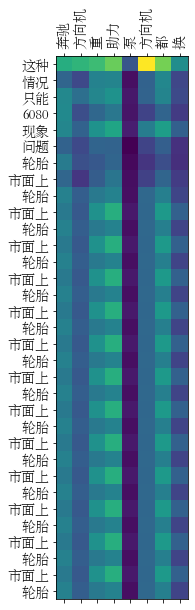

In [52]:
sentence='奔驰的方向机重，助力泵，方向机都换了还是一样'
translate(sentence)